In [11]:
import biom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from skbio.stats.composition import closure
from gemelli.joint_ctf import joint_ctf
from gemelli.tempted import tempted_factorize
from gemelli.preprocessing import clr_transformation
from helper_functions import create_sim_data, plot_loadings

fig_path = '/Users/bec5786/Desktop/temp_figs/'
%matplotlib inline
data_path = '../ipynb/tutorials/'

### Functions

In [3]:
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

def sine_func(x,tps=10):
    amp = 1
    phase = 0
    t = np.linspace(0, 1, tps)
    signal = amp*(1+np.sin(2*np.pi*(t + phase)))
    return np.multiply(x, signal)

### Test 0

Run Joint-CTF on "real data" + two modalities with constant noise

In [4]:
true_mod1, _, noise_mod1, mf_mod1 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
                                                    rank=2, C_=2e3, plotting=False)
_, _, noise_mod2, mf_mod2 = create_sim_data('mod2', n_timepoints=4, n_subjects=12, 
                                            rank=2, C_=1e3, plotting=False)

In [5]:
#ensure features add up to 1 in each sample
mod1_array = true_mod1.to_dataframe().T.values
true_mod1_closed = closure(softmax(mod1_array))
true_mod1_closed = biom.Table(true_mod1_closed.T, true_mod1.to_dataframe().index, 
                              true_mod1.to_dataframe().columns)
#apply clr transformation
true_mod1_clr = clr_transformation(true_mod1_closed, pseudocount=0.01)
true_mod1_clr = true_mod1_clr.to_dataframe().values + 2
true_mod1_clr = biom.Table(true_mod1_clr, true_mod1.to_dataframe().index, 
                           true_mod1.to_dataframe().columns)

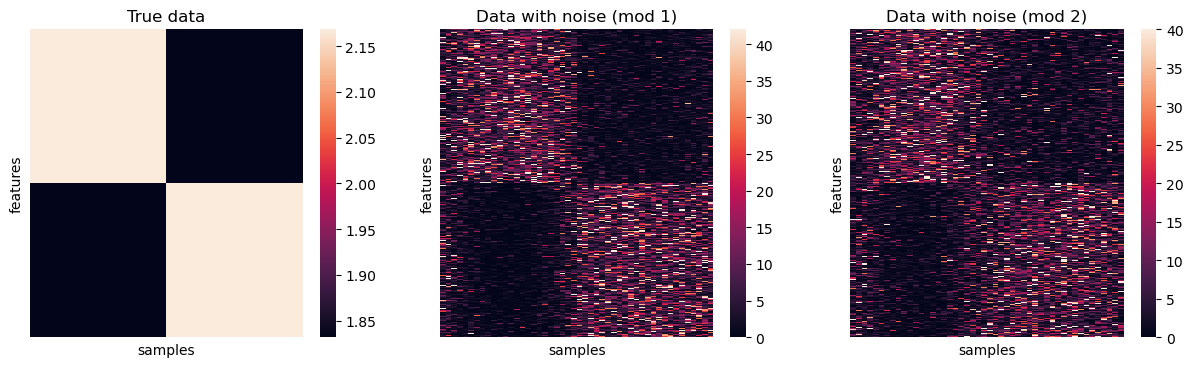

In [6]:
# plot data
fig, axn = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(true_mod1_clr.matrix_data.toarray(), robust=False, 
            ax=axn[0], xticklabels=False, yticklabels=False)
sns.heatmap(noise_mod1.matrix_data.toarray(), robust=True, 
            ax=axn[1], xticklabels=False, yticklabels=False)
sns.heatmap(noise_mod2.matrix_data.toarray(), robust=True, 
            ax=axn[2], xticklabels=False, yticklabels=False)
plt.setp(axn, xlabel="samples", ylabel="features")
axn[0].set_title('True data', color='black', fontsize=12)
axn[1].set_title('Data with noise (mod 1)', color='black', fontsize=12)
axn[2].set_title('Data with noise (mod 2)', color='black', fontsize=12)
#plt.savefig('{}{}_sim_data_heatmap.png'.format(fig_path, C_mod2),
#            bbox_inches='tight')
plt.show()

In [7]:
#run joint-ctf
(subject_loads, feature_loads, state_loads,
evals, var_explained, feature_covs) = joint_ctf(tables=[noise_mod1, noise_mod2],
                                                sample_metadatas=[mf_mod1, mf_mod2],
                                                modality_ids=['mod1', 'mod2'],
                                                individual_id_column='ind_id',
                                                state_column='timepoint')

Calculate components for component_1
Reached convergence in 6 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 14 iterations


In [8]:
print(evals)
print(var_explained.T)

      component_1  component_2  component_3
mod1  3888.263599  2408.896530  1380.917811
mod2  3021.169639  1337.742068   966.001542
               component_1  component_2  component_3
var_explained     0.542006     0.285373     0.172621


In [9]:
#run joint-ctf
(true_subject_loads, true_feature_loads, 
true_state_loads, true_evals,
true_var_explained, true_feature_covs) = joint_ctf(tables=[true_mod1_clr],
                                                   sample_metadatas=[mf_mod1],
                                                   modality_ids=['mod0'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')

Calculate components for component_1
Reached convergence in 2 iterations
Calculate components for component_2
Reached convergence in 3 iterations
Calculate components for component_3
Reached convergence in 4 iterations


In [10]:
print(true_evals)
print(true_var_explained.T)

      component_1  component_2  component_3
mod0   130.960616     0.000146     0.000002
               component_1   component_2   component_3
var_explained          1.0  1.045524e-10  3.092136e-17


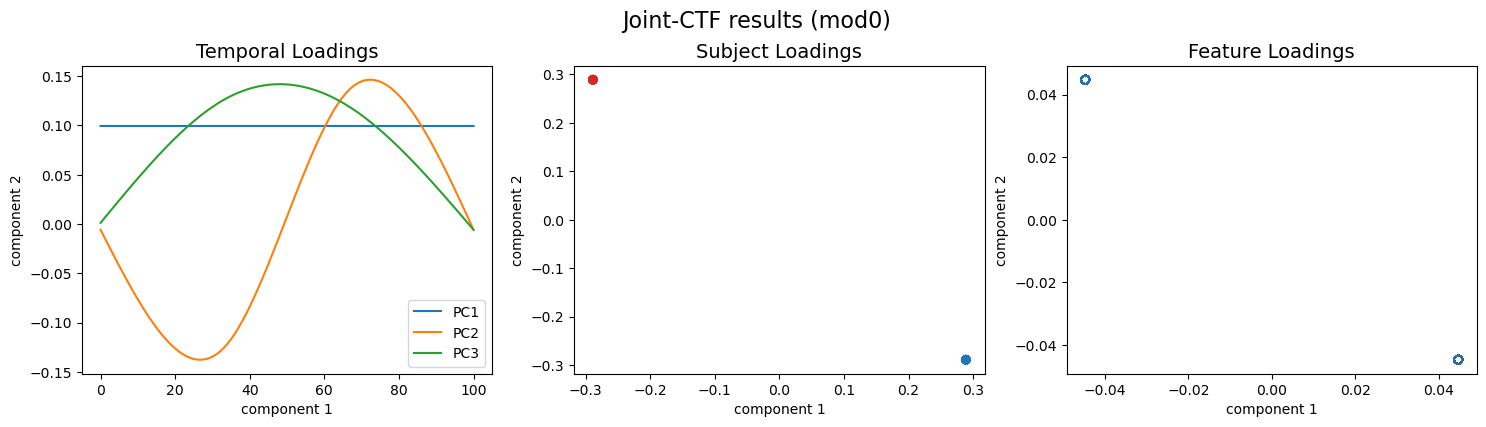

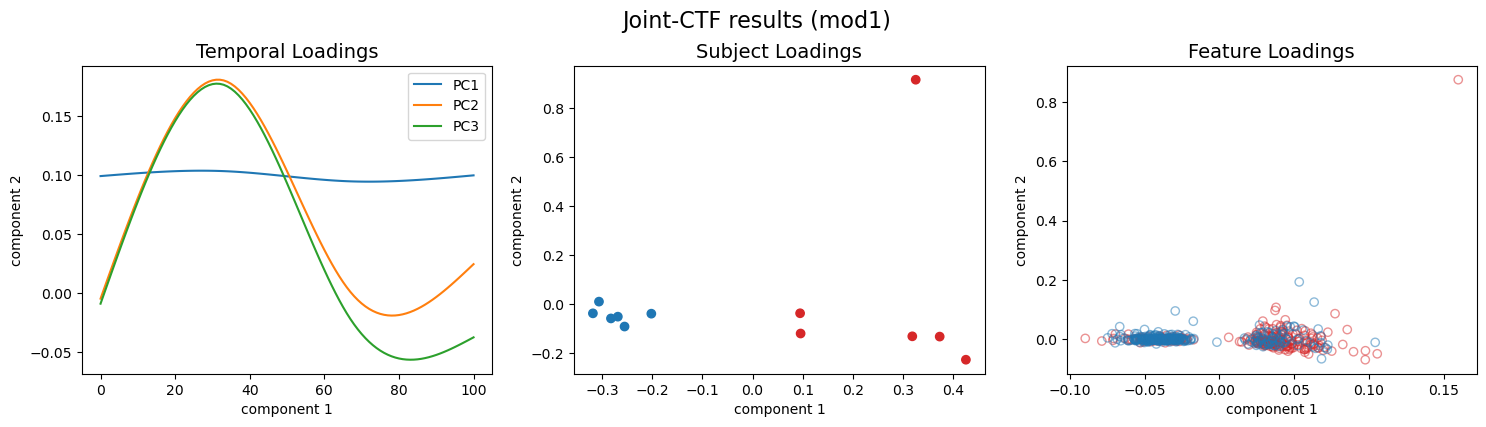

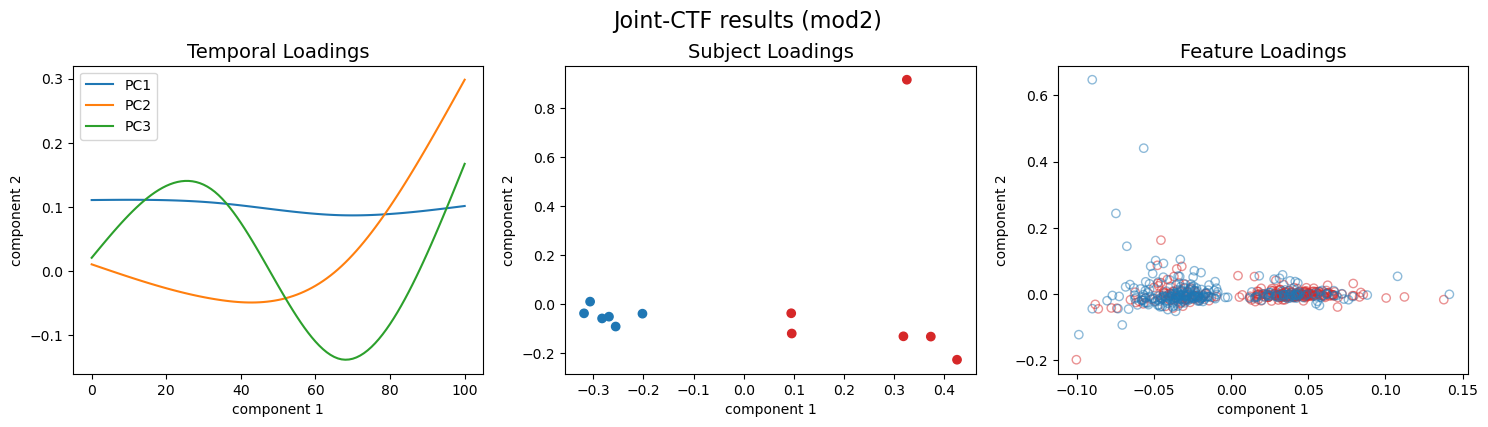

In [ ]:
plot_loadings(loadings=[true_state_loads, true_feature_loads, true_subject_loads],
              mf=mf_mod1, group_colors=group_colors,
              comp1='component_1', comp2='component_2', mod_name='mod0',
              ft_groups=[(0,250), (250,500)], ft_names=['group1','group2','group3'])

plot_loadings(loadings=[state_loads, feature_loads, subject_loads],
              mf=mf_mod1, group_colors=group_colors,
              comp1='component_1', comp2='component_2', mod_name='mod1',
              ft_groups=[(0,250), (250,500)], ft_names=['group1','group2','group3'])

plot_loadings(loadings=[state_loads, feature_loads, subject_loads],
              mf=mf_mod2, group_colors=group_colors,
              comp1='component_1', comp2='component_2', mod_name='mod2',
              ft_groups=[(0,250), (250,500)], ft_names=['group1','group2','group3'])

#ft_groups=[(0,167),(167,332),(332,500)] #3 group case

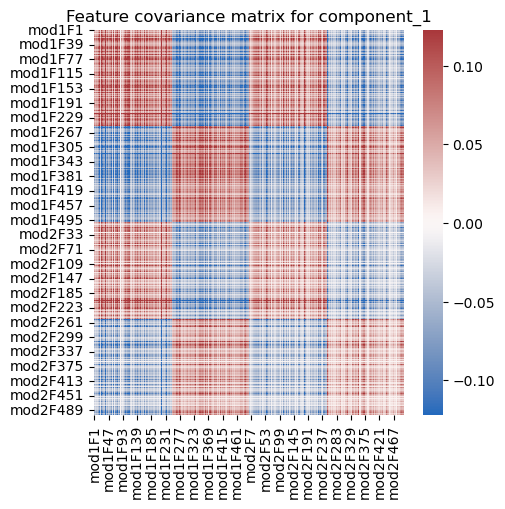

In [13]:
#get feature cov matrix and reorder IDs
feature_order1 = noise_mod1.ids(axis='observation').tolist()
feature_order2 = noise_mod2.ids(axis='observation').tolist()
feature_order = feature_order1 + feature_order2

component = 'component_1'
cov_table = feature_covs[component]
cov_table = cov_table.loc[feature_order, feature_order]

#plot heatmap of feature covariance matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cov_table, robust=True, cmap='vlag', center=0)
plt.title('Feature covariance matrix for {}'.format(component))
plt.show()

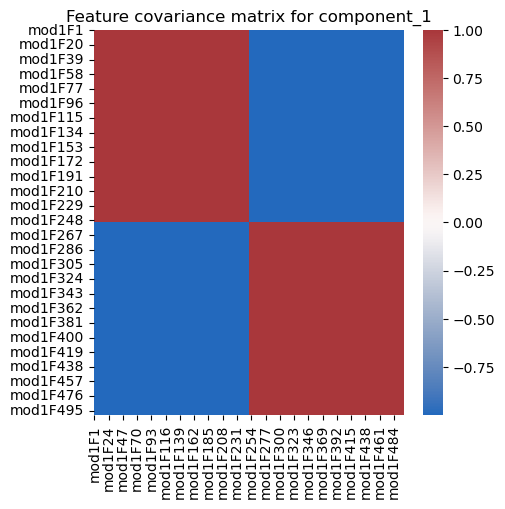

In [14]:
true_order = true_mod1.ids(axis='observation').tolist()
true_cov_table = true_feature_covs[component]
true_cov_table = true_cov_table.loc[true_order, true_order]

plt.figure(figsize=(5, 5))
sns.heatmap(true_cov_table, robust=True, cmap='vlag', center=0)
plt.title('Feature covariance matrix for {}'.format(component))
plt.show()

### Comparison with TEMPTED

In [15]:
tempted_res = tempted_factorize(true_mod1_clr, mf_mod1,
                                'ind_id', 'timepoint')

Prop explained: [1.         0.99969819 0.78205865]
Prop explained argsort: [0 1 2]
Eigenvalues pre-sorting: [1.30960616e+02 1.45777695e-04 2.35602792e-06]
Eigenvalues post-sorting: [1.30960616e+02 1.45777695e-04 2.35602792e-06]


In [16]:
tempted_res_noisy1 = tempted_factorize(noise_mod1, mf_mod1,
                                      'ind_id', 'timepoint')
tempted_res_noisy2 = tempted_factorize(noise_mod2, mf_mod2,
                                      'ind_id', 'timepoint')

Prop explained: [0.16139368 0.06157954 0.04619615]
Prop explained argsort: [0 1 2]
Eigenvalues pre-sorting: [3896.66493553 2410.97823229 1180.44925727]
Eigenvalues post-sorting: [3896.66493553 2410.97823229 1180.44925727]
Prop explained: [0.11203047 0.0542009  0.04295412]
Prop explained argsort: [0 1 2]
Eigenvalues pre-sorting: [3041.8082563  1348.35463685 1083.02404211]
Eigenvalues post-sorting: [3041.8082563  1348.35463685 1083.02404211]


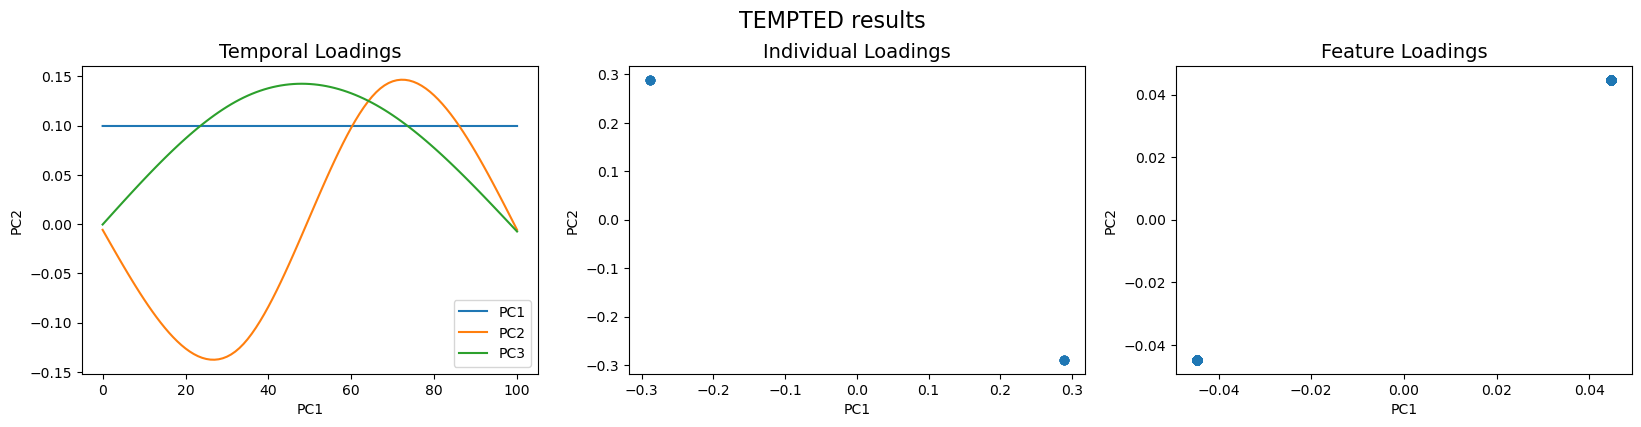

In [17]:
#feature loadings
comp1 = 'PC1'
comp2 = 'PC2'

fig, axn = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
axn[0].plot(tempted_res[1][['PC1', 'PC2', 'PC3']])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend(['PC1', 'PC2', 'PC3'])
axn[1].scatter(tempted_res[0].samples[comp1],
               tempted_res[0].samples[comp2])
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(tempted_res[0].features[comp1],
               tempted_res[0].features[comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('TEMPTED results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

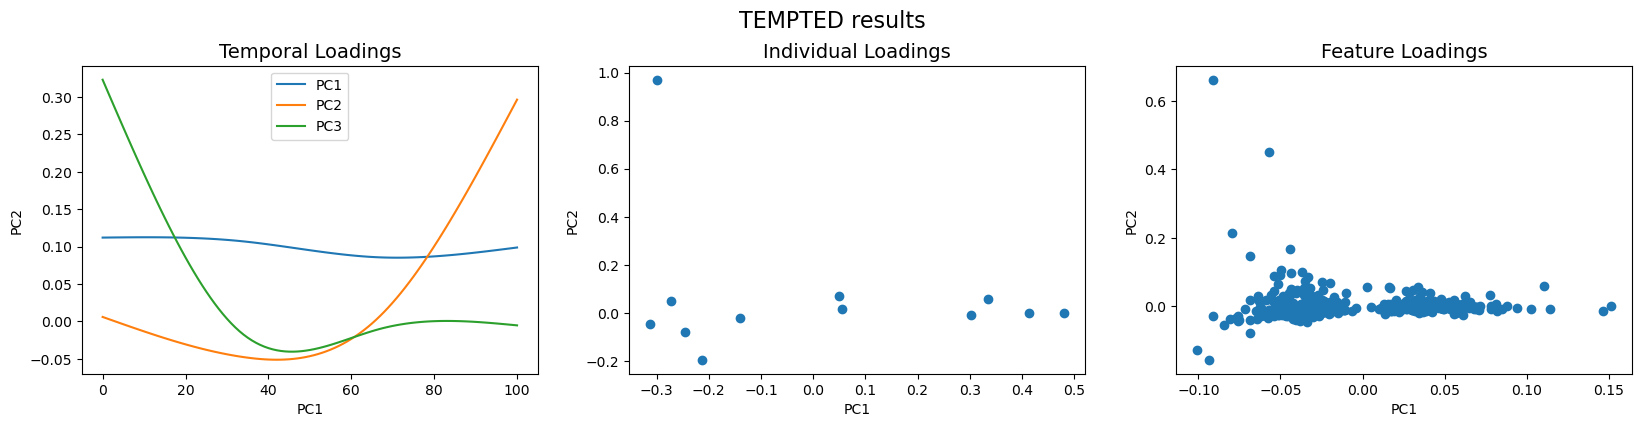

In [18]:
#feature loadings
comp1 = 'PC1'
comp2 = 'PC2'

fig, axn = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
axn[0].plot(tempted_res_noisy2[1][['PC1', 'PC2', 'PC3']])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend(['PC1', 'PC2', 'PC3'])
axn[1].scatter(tempted_res_noisy2[0].samples[comp1],
               tempted_res_noisy2[0].samples[comp2])
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(tempted_res_noisy2[0].features[comp1],
               tempted_res_noisy2[0].features[comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('TEMPTED results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

In [19]:
#run joint-ctf
(subject_loads, feature_loads, state_loads,
evals, var_explained, feature_covs) = joint_ctf(tables=[noise_mod2],
                                                sample_metadatas=[mf_mod2],
                                                modality_ids=['mod2'],
                                                individual_id_column='ind_id',
                                                state_column='timepoint')
print(evals)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 6 iterations
Calculate components for component_2
Reached convergence in 9 iterations
Calculate components for component_3
Reached convergence in 12 iterations
      component_1  component_2  component_3
mod2  3040.599514   1346.98951  1083.004483
               component_1  component_2  component_3
var_explained     0.570805     0.245847     0.183348


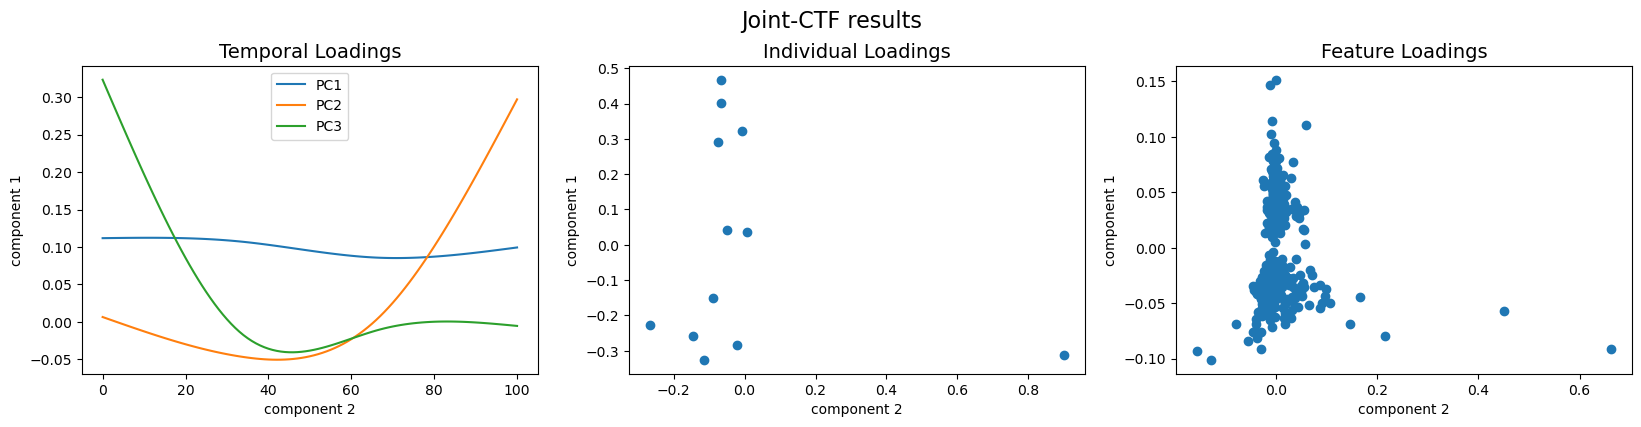

In [20]:
#feature loadings
comp1 = 'component_2'
comp2 = 'component_1'

fig, axn = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
axn[0].plot(state_loads['mod2'][['component_1', 'component_2', 'component_3']])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend(['PC1', 'PC2', 'PC3'])
axn[1].scatter(subject_loads['mod2'][comp1],
               subject_loads['mod2'][comp2])
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(feature_loads['mod2'][comp1],
               feature_loads['mod2'][comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('Joint-CTF results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()